In [1]:
import os
import utils
import model_scoring
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"  # or choose another backend if you wish
import pandas as pd
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource, DatetimeTickFormatter
from bokeh.models.tools import HoverTool
from bokeh.io.export import get_screenshot_as_png
from bokeh.io import output_notebook
import sklearn
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import datetime
import keras
from keras.models import Sequential, Model
from keras.layers import Embedding, Flatten, Dense, Dropout, Input

Using plaidml.keras.backend backend.


In [2]:
output_notebook()

Loading BokehJS ...

In [3]:
train, test = utils.load_data()

Now, we will normalize the data.

In [4]:
mean = train.mean(axis=0)
std = train.std(axis=0)

utils.preprocess(train, mean, std)
utils.preprocess(test, mean, std)

In [5]:
labels = train['target'].tolist()
train.drop(columns=['target'], inplace=True)
train.head()

,PRCP,TMAX,TMIN,day_of_year_1,day_of_year_2,day_of_year_3,day_of_year_4,day_of_year_5,day_of_year_6,day_of_year_7,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
2005-03-03,-0.364319,-1.644261,-1.547583,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2016-01-17,-0.238134,-1.149823,-1.126503,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-06-06,0.115184,0.718051,0.678123,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2010-08-18,-0.364319,1.267426,1.399974,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2011-09-29,0.645160,0.553239,0.738277,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [6]:
main_input = Input(shape=(train.shape[1],), name='main_input')

x = Dense(128, activation='relu')(main_input)
x = Dropout(.25)(x)
x = Dense(64, activation='relu')(x)

output = Dense(1, name='output')(x)

model = Model(inputs=[main_input], outputs=output)
model.summary()

INFO:plaidml:Opening device "metal_amd_radeon_rx_580.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 441)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               56576     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
output (Dense)               (None, 1)                 65        
Total params: 64,897
Trainable params: 64,897
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['mae'])
history = model.fit([train], labels,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.2,
                   )

Train on 3969 samples, validate on 993 samples
Epoch 1/20
3969/3969 [==============================] - 1s 161us/step - loss: 0.2487 - mean_absolute_error: 0.3585 - val_loss: 0.0995 - val_mean_absolute_error: 0.2369
Epoch 2/20
3969/3969 [==============================] - 1s 127us/step - loss: 0.1183 - mean_absolute_error: 0.2475 - val_loss: 0.0819 - val_mean_absolute_error: 0.2228
Epoch 3/20
3969/3969 [==============================] - 0s 120us/step - loss: 0.0984 - mean_absolute_error: 0.2260 - val_loss: 0.0792 - val_mean_absolute_error: 0.2145
Epoch 4/20
3969/3969 [==============================] - 1s 135us/step - loss: 0.0932 - mean_absolute_error: 0.2208 - val_loss: 0.0747 - val_mean_absolute_error: 0.2044
Epoch 5/20
3969/3969 [==============================] - 0s 125us/step - loss: 0.0835 - mean_absolute_error: 0.2080 - val_loss: 0.0723 - val_mean_absolute_error: 0.2009
Epoch 6/20
3969/3969 [==============================] - 0s 119us/step - loss: 0.0779 - mean_absolute_error: 0.202

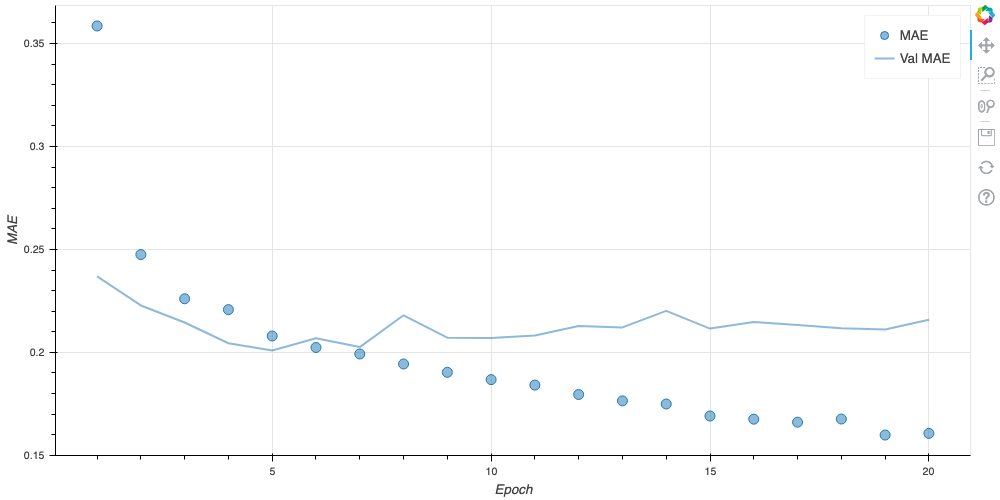

In [8]:
source = pd.DataFrame(history.history)
source['epoch'] = source.index + 1
acc_plot = figure(plot_width=1000, plot_height=500, x_axis_label='Epoch', y_axis_label='MAE')
acc_plot.circle(x='epoch', y='mean_absolute_error', source=source, size=10, fill_alpha=.5, legend_label='MAE')
acc_plot.line(x='epoch', y='val_mean_absolute_error', source=source, line_width=2, legend_label='Val MAE', alpha=0.5)
# show(acc_plot)
get_screenshot_as_png(acc_plot, driver=None)

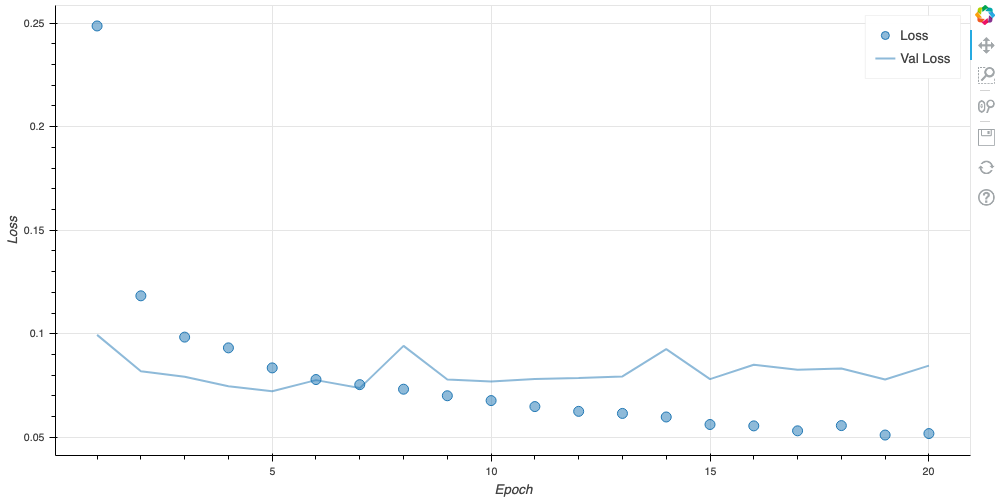

In [9]:
loss_plot = figure(plot_width=1000, plot_height=500, x_axis_label='Epoch', y_axis_label='Loss')
loss_plot.circle(x='epoch', y='loss', source=source, size=10, fill_alpha=.5, legend_label='Loss')
loss_plot.line(x='epoch', y='val_loss', source=source, line_width=2, legend_label='Val Loss', alpha=0.5)
# show(loss_plot)
get_screenshot_as_png(loss_plot, driver=None)

In [10]:
eval_results, pred_plot = model_scoring.eval(model, mean, std)

Total prediction error: 115252.0
Total ISOLF prediction error: 63146.0
Percentage of time the model outperformed the NYISO model: 32.12


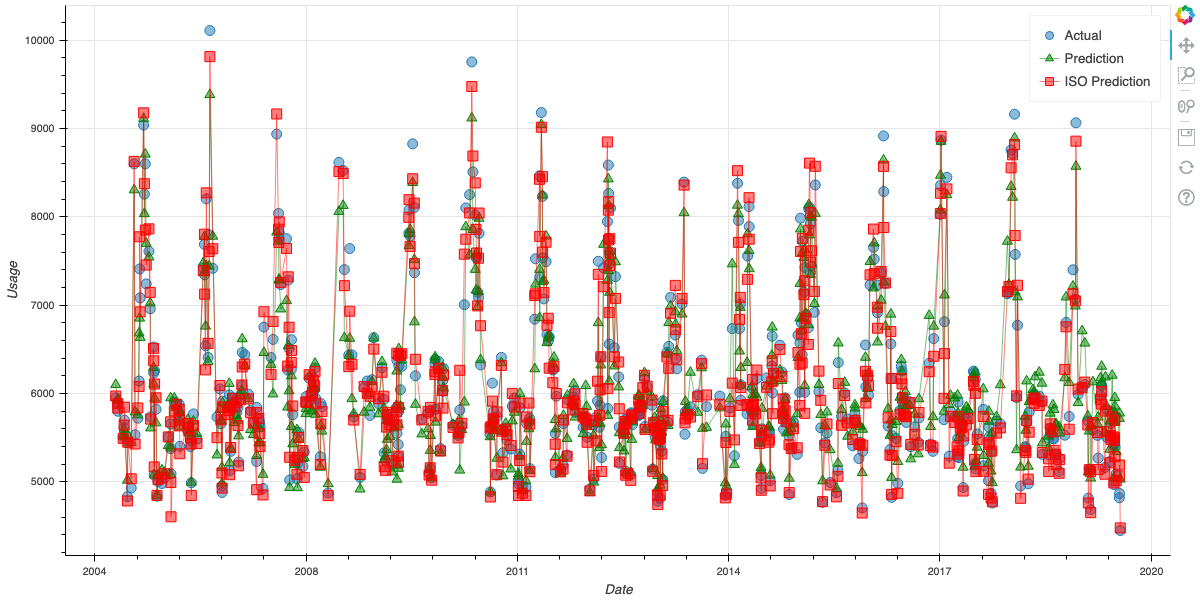

In [11]:
# show(pred_plot)
get_screenshot_as_png(pred_plot, driver=None)

In [12]:
eval_results

,prediction_error,isolf_error,prediction,isolf_mean,target,date,PRCP,TMIN,TMAX
2020-03-25,-908.57,-322.34,5776.11,5189.88,4707722.44,2020-03-25,0.01,40.0,45.0
2020-03-24,-898.02,-246.79,5716.03,5064.79,4659882.38,2020-03-24,0.00,36.0,55.0
2015-06-08,-838.86,150.33,6852.85,5863.67,5815103.69,2015-06-08,0.06,63.0,79.0
2014-06-03,-732.64,616.32,7465.54,6116.58,6509507.94,2014-06-03,0.12,65.0,87.0
2015-06-09,-672.58,240.98,7243.55,6330.00,6353102.34,2015-06-09,0.01,68.0,83.0
...,...,...,...,...,...,...,...,...,...
2008-09-06,1017.50,709.37,6622.03,6930.17,7385238.54,2008-09-06,3.26,70.0,81.0
2016-09-10,1024.83,407.11,7259.99,7877.71,8008522.23,2016-09-10,0.00,74.0,90.0
2011-07-13,1060.09,39.24,7403.23,8424.08,8180941.27,2011-07-13,0.11,69.0,86.0
2010-05-27,1102.18,-572.78,5901.34,7576.29,6770896.75,2010-05-27,0.06,55.0,83.0


In [13]:
eval_results.round(1)

,prediction_error,isolf_error,prediction,isolf_mean,target,date,PRCP,TMIN,TMAX
2020-03-25,-908.6,-322.3,5776.1,5189.9,4707722.4,2020-03-25,0.0,40.0,45.0
2020-03-24,-898.0,-246.8,5716.0,5064.8,4659882.4,2020-03-24,0.0,36.0,55.0
2015-06-08,-838.9,150.3,6852.8,5863.7,5815103.7,2015-06-08,0.1,63.0,79.0
2014-06-03,-732.6,616.3,7465.5,6116.6,6509507.9,2014-06-03,0.1,65.0,87.0
2015-06-09,-672.6,241.0,7243.6,6330.0,6353102.3,2015-06-09,0.0,68.0,83.0
...,...,...,...,...,...,...,...,...,...
2008-09-06,1017.5,709.4,6622.0,6930.2,7385238.5,2008-09-06,3.3,70.0,81.0
2016-09-10,1024.8,407.1,7260.0,7877.7,8008522.2,2016-09-10,0.0,74.0,90.0
2011-07-13,1060.1,39.2,7403.2,8424.1,8180941.3,2011-07-13,0.1,69.0,86.0
2010-05-27,1102.2,-572.8,5901.3,7576.3,6770896.8,2010-05-27,0.1,55.0,83.0
